In [1]:
import scipy 
import numpy as np
import pandas as pd
import pandas.api.types as ptypes
import matplotlib.pyplot as plt
import seaborn as sns
import rdkit
import os
import sys

In [2]:
class DataProcessor():
    
    """
    This class loads molecular fingerprints into a DataFrame and performs clean-up on them.

    Parameters
    ----------
    protein : str
        The protein name, one of ['5ht1a', '5ht7', 'beta2', 'd2', 'h1'].
    fingerprint : str
        The fingerprint type, one of ['Klek', 'Sub', 'MACCS'].
    y_col : str, optional
        The name of the column representing the dependent variable, default is 'Ki'.

    Attributes
    ----------
    data_paths_ : dict
        A dictionary containing the paths to the fingerprint files.
    proteins_ : list of str
        The list of valid protein names.
    fingerprints_ : list of str
        The list of valid fingerprint types.
    protein : str
        The protein name.
    fingerprint : str
        The fingerprint type.
    path : str
        The path to the fingerprint file.
    df : pandas.DataFrame
        The DataFrame containing the loaded fingerprint data.

    Methods
    -------
    remove_missing()
        Removes rows with missing values in the dependent variable column.
    remove_duplicates()
        Removes duplicate rows in the DataFrame.
    remove_redundant()
        Removes redundant columns in the DataFrame.
    convert_data()
        Converts the data types of the columns in the DataFrame.
    add_classification(threshold)
        Adds a Class column to the DataFrame based on the threshold parameter.
    write_cleaned()
        Writes the cleaned DataFrame to a csv file.
    """
    
    def __init__(self, protein, fingerprint, y_col='Ki'):
        sys.path.append('..')
        self.data_paths_ = {
    '5ht1a_Klek' : './datasets/5ht1a_KlekFP.csv',
    '5ht1a_MACCS' : './datasets/5ht1a_MACCSFP.csv',
    '5ht1a_Sub' : './datasets/5ht1a_SubFP.csv',
    '5ht7_Klek' : './datasets/5ht7_KlekFP.csv',
    '5ht7_MACCS' : './datasets/5ht7_MACCSFP.csv',
    '5ht7_Sub' : './datasets/5ht7_SubFP.csv',
    'beta2_Klek' : './datasets/beta2_KlekFP.csv',
    'beta2_MACCS' : './datasets/beta2_MACCSFP.csv',
    'beta2_Sub' : './datasets/beta2_SubFP.csv',
    'd2_Klek' : './datasets/d2_KlekFP.csv',
    'd2_MACCS' : './datasets/d2_MACCSFP.csv',
    'd2_Sub' : './datasets/d2_SubFP.csv',
    'h1_Klek' : './datasets/h1_KlekFP.csv',
    'h1_MACCS' : './datasets/h1_MACCSFP.csv',
    'h1_Sub' : './datasets/h1_SubFP.csv'
    }
            
        self.proteins_ = ['5ht1a', '5ht7', 'beta2', 'd2', 'h1']
        self.fingerprints_ = ['Klek', 'Sub', 'MACCS']
        self.y_col = y_col
        self.missing = None
        self.duplicated = None
        self.redundant = None
        
        self.protein = protein
        self.fingerprint = fingerprint
        self.path = self.protein + '_' + self.fingerprint
        if self.path in self.data_paths_.keys():
            self.df = pd.read_csv(self.data_paths_[self.path])
            print(f'{self.fingerprint} FP for protein {self.protein} loaded')
        else:
            self.df = None
            print("Protein and fingerprint combination not found")
        
        
    def remove_missing(self):
        print(f'The initial size of dataset: {len(self.df)}')
        missing = self.df[self.y_col].isnull()
        zero_or_neg = self.df[self.y_col] <= 0
        to_remove = pd.Series([a or b for a, b in zip(missing,zero_or_neg)])
        print(f'The percent of rows with missing {self.y_col} values: {to_remove.sum()/len(self.df)*100:.2f} %')
        self.df = self.df[~to_remove]
        print(f'New size of the dataset: {len(self.df)}')
        self.missing = int(to_remove.sum())
        
    
    def remove_duplicates(self):
        print(f'The initial size of dataset: {len(self.df)}')
        duplicates = self.df.duplicated(keep = 'first')
        print(f'The percent of duplicated rows: {duplicates.sum()/len(self.df)*100:.2f} %')
        self.df = self.df[~duplicates]
        print(f'New size of the dataset: {len(self.df)}')
        self.duplicated = int(duplicates.sum())
        
        
    def remove_redundant(self):
        col1 = len(self.df.columns)
        selection = [True if sum > 0 else False for sum in self.df.sum(axis=0)]
        self.df = self.df.loc[:, selection]
        col2 = len(self.df.columns)
        print(f'There were {col1-col2} redundant columns in the dataset.')
        self.redundant = int(col1 - col2)
        
        
    def convert_data(self):
        self.df[self.y_col] = self.df[self.y_col].astype(float)
        columns = self.df.columns[1:]
        self.df[columns] = self.df[columns].astype(int)
        
        
    def add_classification(self, threshold = 100):
        classes = [1 if x < threshold else 0 for x in self.df[self.y_col]]
        self.df.insert(1, "Class", classes)
        print(f'The percent of compounds classified as active is {self.df["Class"].sum()/len(self.df)*100:.2f} %')
        
                
    def write_cleaned(self):
        write_path = './cleaned_datasets/' + self.path + '_clean.csv'
        self.df.to_csv(path_or_buf=write_path, sep=',', index=False)
        print(f'Cleaned file saved at {write_path}')
    
    
    def return_parameters(self): # zwraca listę list dotyczącą ile czego brakowało/usunięto w kolejności wczytania do klasy
        parameters = []
        parameters.append(self.missing)
        parameters.append(self.duplicated)
        parameters.append(self.redundant)
        return parameters

In [11]:
# test

data = DataProcessor(protein='5ht1a', fingerprint='MACCS')
data.remove_missing()
data.remove_duplicates()
data.remove_redundant()
data.add_classification()
data.convert_data()

# data.write_cleaned()

MACCS FP for protein 5ht1a loaded
The initial size of dataset: 5851
The percent of rows with missing Ki values: 3.79 %
New size of the dataset: 5629
The initial size of dataset: 5629
The percent of duplicated rows: 8.33 %
New size of the dataset: 5160
There were 18 redundant columns in the dataset.
The percent of compounds classified as active is 58.18 %


In [35]:
# przygotowanie danych

proteins = ['5ht1a', '5ht7', 'beta2', 'd2', 'h1']
keys = ['Klek', 'Sub', 'MACCS']

deleted = [] # przechowywanie informacji o zmianach

for protein in proteins:
        for key in keys:
            data = DataProcessor(protein=protein, fingerprint=key)
            data.remove_missing()
            data.remove_duplicates()
            data.remove_redundant()
            data.add_classification()
            data.convert_data()
            # parameters = data.return_parameters()
            # deleted.append(parameters)
            data.write_cleaned()
            print('\n')
            del data

Klek FP for protein 5ht1a loaded
The initial size of dataset: 5851
The percent of rows with missing Ki values: 3.79 %
New size of the dataset: 5629
The initial size of dataset: 5629
The percent of duplicated rows: 7.66 %
New size of the dataset: 5198
There were 3263 redundant columns in the dataset.
The percent of compounds classified as active is 58.10 %
Cleaned file saved at ./cleaned_datasets/5ht1a_Klek_clean.csv


Sub FP for protein 5ht1a loaded
The initial size of dataset: 5851
The percent of rows with missing Ki values: 3.79 %
New size of the dataset: 5629
The initial size of dataset: 5629
The percent of duplicated rows: 10.23 %
New size of the dataset: 5053
There were 190 redundant columns in the dataset.
The percent of compounds classified as active is 58.60 %
Cleaned file saved at ./cleaned_datasets/5ht1a_Sub_clean.csv


MACCS FP for protein 5ht1a loaded
The initial size of dataset: 5851
The percent of rows with missing Ki values: 3.79 %
New size of the dataset: 5629
The initi

In [90]:
# Zliczenia dla MACCSÓW, jeżeli FP to powinno Ci wypluć normalnie wszystkie dane ile czego w nich jest; raczej nie próbuj 
# loopa bo się potem dalsze zepsują

proteins = ['5ht1a', '5ht7', 'beta2', 'd2', 'h1']
data = []
new = pd.DataFrame()

for protein in proteins:
    df = DataProcessor(protein, "MACCS")
    df.remove_missing()
    df.remove_duplicates()
    x = list(df.df.columns[1:])
    y = list(df.df.iloc[:, 1:].sum().astype('int'))
    frame = pd.DataFrame({'Key' : x, 'Count' : y})
    freq = list(frame['Count'])
    leng = np.max(freq)
    new_values = []
    for value in freq:
        new_values.append(value/leng*100)
    frame['Freq'] = pd.Series(new_values).astype('float')
    data.append(frame)
    new[protein] = y
new['keys'] = x

MACCS FP for protein 5ht1a loaded
The initial size of dataset: 5851
The percent of rows with missing Ki values: 3.79 %
New size of the dataset: 5629
The initial size of dataset: 5629
The percent of duplicated rows: 8.33 %
New size of the dataset: 5160
MACCS FP for protein 5ht7 loaded
The initial size of dataset: 3266
The percent of rows with missing Ki values: 3.89 %
New size of the dataset: 3139
The initial size of dataset: 3139
The percent of duplicated rows: 7.45 %
New size of the dataset: 2905
MACCS FP for protein beta2 loaded
The initial size of dataset: 1667
The percent of rows with missing Ki values: 51.35 %
New size of the dataset: 811
The initial size of dataset: 811
The percent of duplicated rows: 4.44 %
New size of the dataset: 775
MACCS FP for protein d2 loaded
The initial size of dataset: 11821
The percent of rows with missing Ki values: 9.09 %
New size of the dataset: 10746
The initial size of dataset: 10746
The percent of duplicated rows: 7.57 %
New size of the dataset: 

In [96]:
print(data[0].head(n=10))

         Key  Count      Freq
0   MACCSFP1      0  0.000000
1   MACCSFP2      0  0.000000
2   MACCSFP3      4  0.077519
3   MACCSFP4      0  0.000000
4   MACCSFP5      0  0.000000
5   MACCSFP6      0  0.000000
6   MACCSFP7      0  0.000000
7   MACCSFP8     30  0.581395
8   MACCSFP9      0  0.000000
9  MACCSFP10      0  0.000000


In [110]:
# Wybór bitów, które w danym białku są w 90% związków
for key in data:
    selection = [True if x>90 else False for x in key['Freq']]
    new_df = key[selection]
    print(new_df['Key'])

21      MACCSFP22
99     MACCSFP100
110    MACCSFP111
117    MACCSFP118
120    MACCSFP121
127    MACCSFP128
128    MACCSFP129
136    MACCSFP137
137    MACCSFP138
144    MACCSFP145
146    MACCSFP147
152    MACCSFP153
155    MACCSFP156
157    MACCSFP158
160    MACCSFP161
161    MACCSFP162
162    MACCSFP163
163    MACCSFP164
164    MACCSFP165
Name: Key, dtype: object
21      MACCSFP22
99     MACCSFP100
110    MACCSFP111
117    MACCSFP118
120    MACCSFP121
124    MACCSFP125
136    MACCSFP137
141    MACCSFP142
144    MACCSFP145
146    MACCSFP147
152    MACCSFP153
155    MACCSFP156
157    MACCSFP158
160    MACCSFP161
161    MACCSFP162
162    MACCSFP163
164    MACCSFP165
Name: Key, dtype: object
21      MACCSFP22
99     MACCSFP100
103    MACCSFP104
112    MACCSFP113
126    MACCSFP127
142    MACCSFP143
150    MACCSFP151
151    MACCSFP152
152    MACCSFP153
154    MACCSFP155
156    MACCSFP157
157    MACCSFP158
158    MACCSFP159
160    MACCSFP161
161    MACCSFP162
162    MACCSFP163
163    MACCSFP

In [56]:
# przygotowanie do zrobienia wykresów

print(new.head())
newest = pd.melt(new, id_vars='keys', value_vars=['5ht1a', '5ht7', 'beta2', 'd2', 'h1'], var_name="Protein", value_name='Value')
newest['keys'] = newest['keys'].astype('category')

   5ht1a  5ht7  beta2  d2  h1      keys
0      0     0      0   0   0  MACCSFP1
1      0     0      0   0   0  MACCSFP2
2      4     3      0   7   0  MACCSFP3
3      0     0      0   0   0  MACCSFP4
4      0     0      0   0   0  MACCSFP5


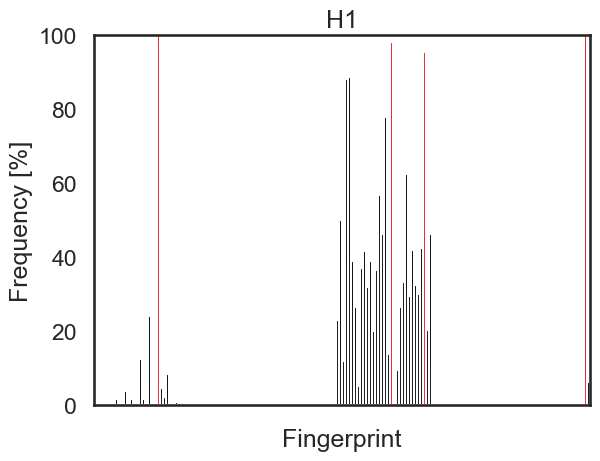

In [94]:
# to ma jakieś problemy i robi dziwne wykresy, próbowałem chyba to samo potem zrobić w tym drugim pliku

titles = ['5HT1A', '5HT7', 'BETA2', 'D2', 'H1']
"""
for i in range(5):
    col = ['red' if (x > 90) else 'black' for x in data[i]["Freq"]]
    ax = sns.barplot(data=data[i], x="Key", y="Freq", palette = col)
    ax.set_xlabel("Fingerprint")
    ax.set_ylabel("Frequency [%]")
    ax.set_xticklabels("")
    title = titles[i]
    ax.set_title(title)
    ax.set_ylim(0,100)
    path = 'C:/MLDD23/' + title +'.png'
    plt.gcf().savefig(path, dpi=300, format='png', bbox_inches='tight')
    del ax
    del path
"""
col = ['red' if (x > 90) else 'black' for x in data[4]["Freq"]]
ax = sns.barplot(data=data[4], x="Key", y="Freq", palette = col)
ax.set_xlabel("Fingerprint")
ax.set_ylabel("Frequency [%]")
ax.set_xticklabels("")
title = titles[4]
ax.set_title(title)
ax.set_ylim(0,100)
path = 'C:/MLDD23/' + title +'.png'
plt.gcf().savefig(path, dpi=300, format='png', bbox_inches='tight')
del ax
del path
    
# plt.savefig("C:/MLDD23/h1.png", dpi=300, format='png', bbox_inches='tight')
# plt.show()

In [39]:
for df in data:
    df['x'] = np.linspace(1,166,166)

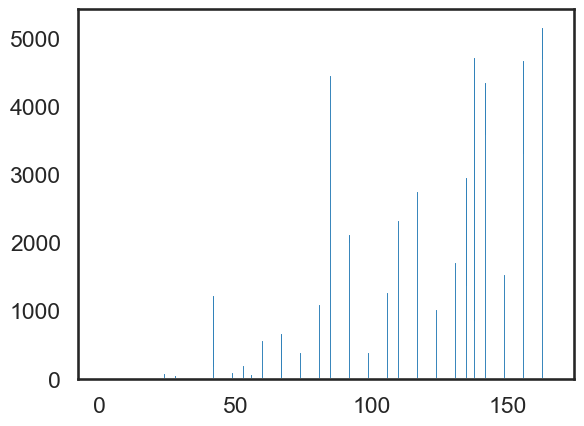

In [47]:
# to chyba też nie działa xd

sns.set_style('white')
sns.set_context('talk')

plt.bar(np.linspace(1,166,166), data[0]['Count'])
# ax.set_xticklabels("")
# ax.set_title("5HT1A")
# plt.subplots_adjust(left=0.20, bottom=0.1)

# plt.savefig("C:/MLDD23/5HT1A.jpg", dpi=300, format='jpg')
plt.show()

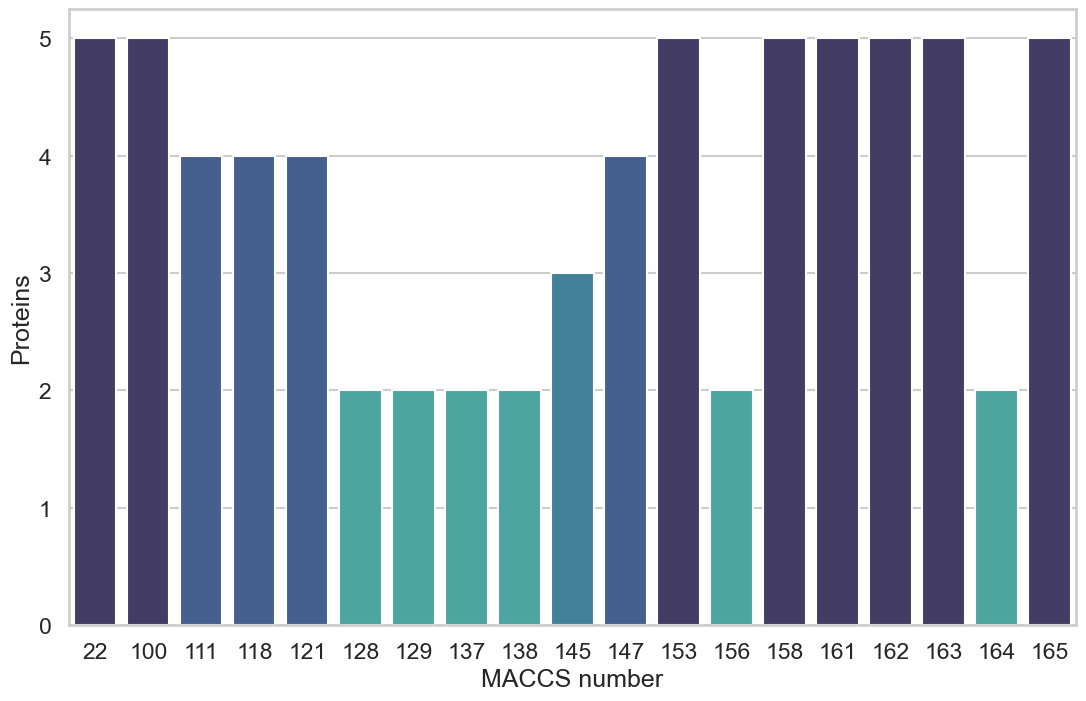

In [10]:
# tutaj ładny wykres na przestrzeni białek, ale liczyłem ręcznie które bity były najczęściej 
sns.set(rc={'figure.figsize':(13,8)})
sns.set_style('whitegrid')
sns.set_context('talk')
fps = np.array([22,100,111,118,121,128,129,137,138,145,147,153,156,158,161,162,163,164,165])
counts = [5,5,4,4,4,2,2,2,2,3,4,5,2,5,5,5,5,2,5]


df_c = pd.DataFrame({"Fingerprint":fps, "Proteins":counts})
col = sns.color_palette("mako", 19) #kolorek
col2 = [col[4] if x == 5 else col[7] if x == 4 else col[10] if x == 3 else col[13] for x in counts] #kolorki w zależności od counta
g = sns.barplot(data=df_c, x="Fingerprint", y="Proteins", palette=col2)
    
g.set_xlabel('MACCS number')
sns.set_style()
# g.tick_params(axis='x', rotation=60)
plt.savefig("C:/MLDD23/Counts.png", dpi=300, format='png', bbox_inches='tight')
plt.show()